In [1]:
import cv2
import numpy as np
import os
import sklearn
import time
from keras.callbacks import ModelCheckpoint
import sys
from skimage.data import imread
from skimage.io import imshow,imsave
from skimage import img_as_float
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from os.path import join
from skimage.util import crop
from skimage.transform import rotate
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pickle
from math import atan2, degrees, pi

sys.path.append('..')
from lib import models
from lib import utils

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: TITAN X (Pascal) (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 5110)


In [2]:
dataset_dir = '/home/ryan/cs/datasets/ncfm'

label_dir = '/home/ryan/cs/kaggle/ncfm/point_annotations'

weights = join(dataset_dir, 'weights/vgg16.h5')

img_dir = join(dataset_dir, 'train')

weights_file = join(dataset_dir, 'weights/vgg16_weights.h5')

aligned_images_pkl = join(dataset_dir, 'classifier_train.pkl')

load_precomputed_train = True
seed = 0
np.random.seed(seed)
vgg_size = (224, 224)
fish_types = ['ALB','BET','DOL','LAG','OTHER','SHARK','YFT']
nb_test_samples = 1000
nb_classes = len(fish_types)
k = 3
nb_epoch_e2e = 15
nb_epoch_localized = 15
nb_epoch = 15
nb_runs = 5
batch_size = 32

In [3]:
json_names = ['alb_labels.json',
              'bet_labels.json',
              'dol_labels.json',
              'lag_labels.json',
              'other_labels.json',
              'shark_labels.json',
              'yft_labels.json',]

label_files = []
for n in json_names:
    label_files.append(join(label_dir, n))

In [4]:
def get_angle(row):
    if len(row['annotations']) < 2:
        return float('NaN')
    p1 = row['annotations'][0]
    p2 = row['annotations'][1]
    return deg_angle_between(p1['x'],p1['y'], p2['x'], p2['y'])

def deg_angle_between(x1,y1,x2,y2):
    
    dx = x2 - x1
    dy = y2 - y1
    rads = atan2(-dy,dx)
    rads %= 2*pi
    degs = degrees(rads)
#     if degs > 180:
#         degs -= 360
    return(degs)


def get_img(row):
    if len(row['annotations']) < 2:
        return float('NaN')
    p1 = row['annotations'][0]
    p2 = row['annotations'][1]

    img = imread(join(img_dir,row['filename']))

    boxed = get_cropped_fish(img, 
        int(p1['x']), int(p1['y']), int(p2['x']), int(p2['y']))

    return boxed
    


def get_cropped_fish(img,x1,y1,x2,y2):
    (h,w) = img.shape[:2]
    #calculate center and angle
    center = ( (x1+x2) / 2,(y1+y2) / 2)
    angle = np.floor(-deg_angle_between(x1,y1,x2,y2))
    
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
#     plt.imshow(rotated)
#     plt.show()
    fish_length = np.sqrt((x1-x2)**2+(y1-y2)**2)
    
    cropped = rotated[(max((center[1]-int(fish_length/1.8)),0)):(max((center[1]+int(fish_length/1.8)),0)) ,
                      (max((center[0]-int(fish_length/1.8)),0)):(max((center[0]+int(fish_length/1.8)),0))]
    resized = resize(cropped,vgg_size)
    
    return resized

In [6]:
if not load_precomputed_train:
    labels = None
    for i in range(len(label_files)):
        f_labels = pd.read_json(label_files[i])
        f_labels['fish'] = i
        if labels is None:
            labels = f_labels
        else:
            labels = labels.append(f_labels)

    labels['rotation'] = labels.apply(get_angle, axis=1)
    labels = labels.dropna()

    print 'Calculated rotations.'

    images = np.zeros((len(labels), vgg_size[0], vgg_size[1], 3))
    counter = 0
    for _, row in labels.iterrows():
        images[counter] = get_img(row)
        if counter % 1000 == 0:
            print 'Finished processing {} images'.format(counter)
        counter += 1

    enc = OneHotEncoder(sparse=False)
    one_hot = enc.fit_transform(labels['fish'].values.reshape(-1,1))
    data = [images, one_hot]
    pickle.dump(data, open(aligned_images_pkl, 'w'))
else:
    data = pickle.load(open(aligned_images_pkl, 'r'))
    images = data[0]
    one_hot = data[1]
    print "Loaded precomputed data"

Calculated rotations.
Finished processing 0 images
Finished processing 1000 images
Finished processing 2000 images
Finished processing 3000 images


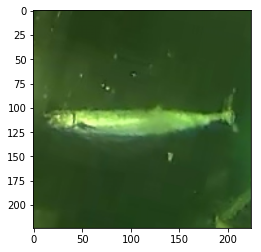

[ 0.  0.  0.  0.  1.  0.  0.]


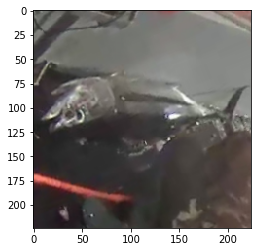

[ 0.  0.  0.  0.  1.  0.  0.]


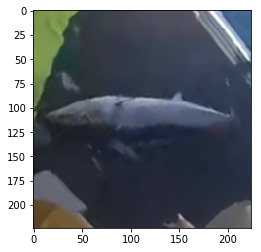

[ 0.  0.  0.  0.  1.  0.  0.]


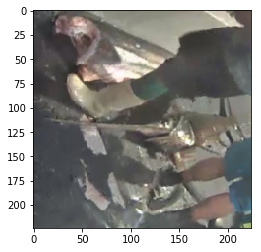

[ 0.  0.  0.  0.  1.  0.  0.]


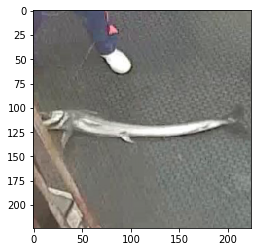

[ 0.  0.  0.  0.  1.  0.  0.]


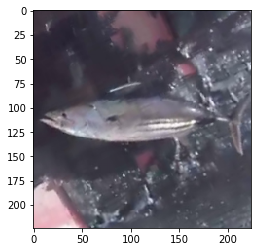

[ 0.  0.  0.  0.  1.  0.  0.]


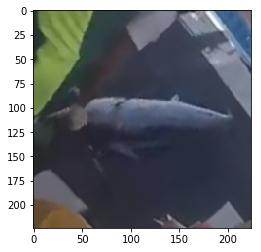

[ 0.  0.  0.  0.  1.  0.  0.]


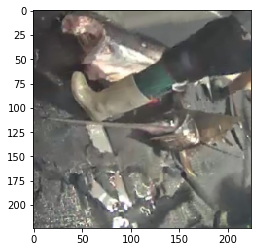

[ 0.  0.  0.  0.  1.  0.  0.]


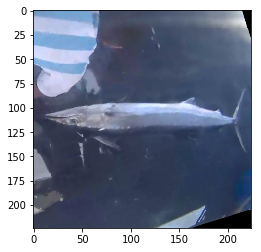

[ 0.  0.  0.  0.  1.  0.  0.]


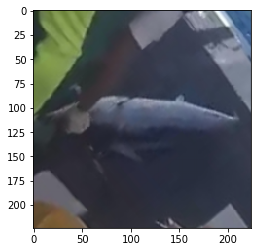

[ 0.  0.  0.  0.  1.  0.  0.]


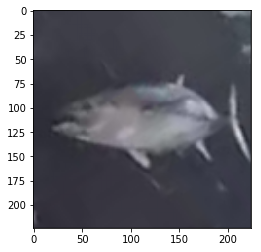

[ 0.  0.  0.  0.  1.  0.  0.]


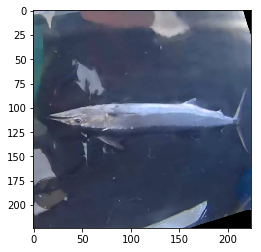

[ 0.  0.  0.  0.  1.  0.  0.]


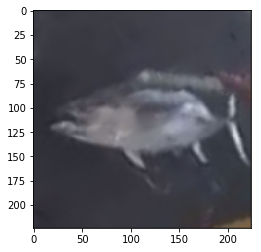

[ 0.  0.  0.  0.  1.  0.  0.]


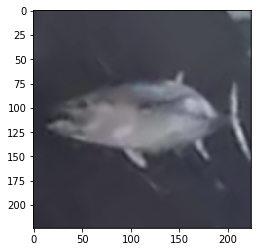

[ 0.  0.  0.  0.  1.  0.  0.]


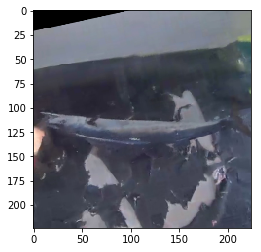

[ 0.  0.  0.  0.  1.  0.  0.]


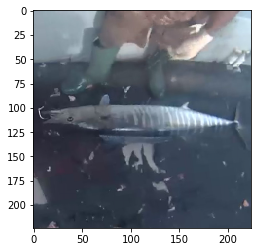

[ 0.  0.  0.  0.  1.  0.  0.]


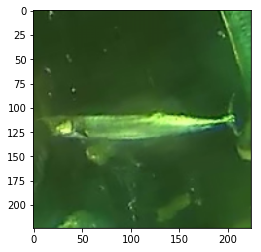

[ 0.  0.  0.  0.  1.  0.  0.]


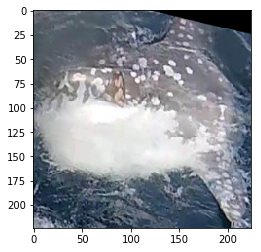

[ 0.  0.  0.  0.  1.  0.  0.]


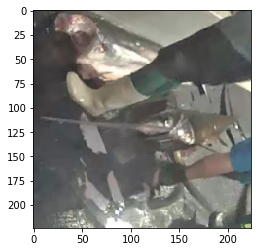

[ 0.  0.  0.  0.  1.  0.  0.]


In [8]:
for index in range(2101, 2120):
    plt.imshow(images[index])
    plt.show()
    print one_hot[index]

In [13]:
images = images.transpose((0,3,1,2))

In [14]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(images, one_hot, test_size=.2)

In [15]:
trn_gen, val_gen = models.get_train_val_gens(X_train, X_val, y_train, y_val, 
                                             size=vgg_size)

In [16]:
model = models.vgg16(size=vgg_size, nb_classes=7, weights_file = weights)

In [ ]:
# models.train_val(model, trn_gen, val_gen, 
#           nb_trn_samples=X_train.shape[0],
#           nb_val_samples=X_val.shape[0],
#           nb_epoch=12)
model.fit(X_train, y_train,
        batch_size=batch_size,
        nb_epoch=nb_epoch,
        validation_data=(X_val, y_val),
        shuffle=True, verbose=1)

Train on 2639 samples, validate on 660 samples
Epoch 1/15
2639/2639 [==============================] - 27s - loss: 0.9124 - acc: 0.7768 - val_loss: 0.8677 - val_acc: 0.7833